# Highlight->Summarize data analysis

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import NOANSWER_PRED
from run_experiments import load_all_results

/home/azureuser/highlight-summarize/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RESULTS_DIR = "results/"
results = load_all_results(RESULTS_DIR)

**Store to Excel for manual inspection**

The results are merged per dataset.

In [22]:
import pandas as pd

datasets_results = {}
for run_id, res in results.items():
    dataset_name = res["config"]["dataset"]
    if dataset_name not in datasets_results:
        datasets_results[dataset_name] = []
    res["run_id"] = run_id
    datasets_results[dataset_name].append(res)
results_df = {}

select = ["question", "answer", "answer_pred", "model_name", "temperature"]
factors = ["correctness", "faithfulness", "naturalness"]
select += [f"MT-bench-QA_{factor}" for factor in factors]
select += [f"MT-bench-QA_{factor}_explanation" for factor in factors]
try_select = ['summarizer_llm_response', 'summarizer_llm_guessed_question', 'highlighter_extracted', 'highlighter_llm_response', 'highlighter_text_extracts', 'highlighter_fuzzmatch_scores']

for dataset_name, dataset_result_list in datasets_results.items():
    to_cat = []

    for res in dataset_result_list:
        judged_predictions = res["judged_dataset"]
        pipeline = res["config"]["pipeline"]
        try:
            to_cat.append(pd.DataFrame(judged_predictions)[select + try_select])
        except KeyError:
            to_cat.append(pd.DataFrame(judged_predictions)[select])
        to_cat[-1]["pipeline"] = pipeline
        to_cat[-1]["run_id"] = res["run_id"]
        if "raw_text_extracts" in judged_predictions.column_names:
            to_cat[-1]["raw_text_extracts"] = judged_predictions["raw_text_extracts"]
        else:
            to_cat[-1]["raw_text_extracts"] = None

    df = pd.concat(to_cat, ignore_index=True)
    df.to_excel(
        os.path.join(f"{RESULTS_DIR}/{dataset_name}", "results.xlsx"),
        index=False,
        engine="openpyxl"
    )
    results_df[dataset_name] = df

In [4]:
plt.hist(df[df.Factor=="correctness"]["factor_score"])

AttributeError: 'DataFrame' object has no attribute 'Factor'

# Evaluation on answerable questions

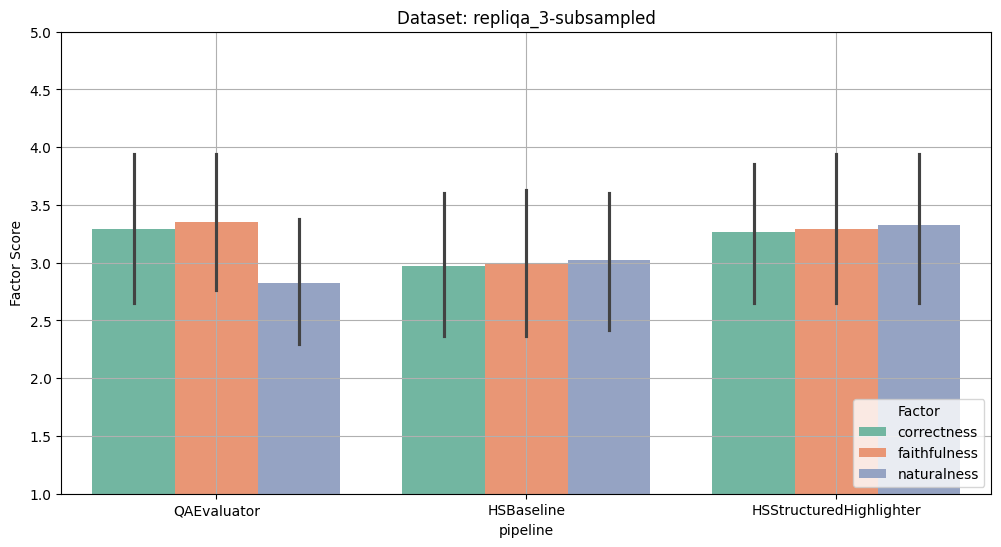

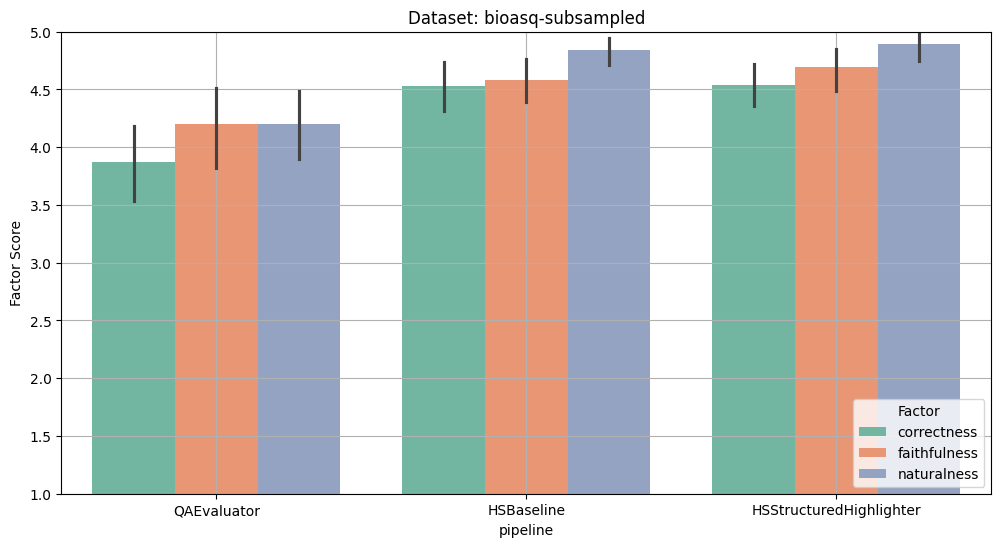

In [ ]:
for dataset_name, df in results_df.items():
    # Filter out no-answer predictions.
    df = df[df.answer_pred != NOANSWER_PRED]
    # Each factor gets a replica of the data, and we then concatenate.
    to_cat = []
    for factor in factors:
        df_factor = df.copy()
        df_factor["factor"] = factor
        df_factor["factor_score"] = df_factor[f"MT-bench-QA_{factor}"]
        to_cat.append(df_factor)
    df = pd.concat(to_cat, ignore_index=True)

    # Violin plot for each run_id (i.e., config). Hue is the factor.
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="pipeline",
        y="factor_score",
        hue="factor",
        data=df,
        palette="Set2",
    )
    plt.ylabel("Factor Score")
    plt.ylim(1, 5)
    plt.grid()
    plt.legend(loc="lower right", title="Factor")
    plt.title(f"Dataset: {dataset_name}")

# Ablation study on H&S

##### Correct questions (among those that can be answered)

In [ ]:
MIN_RATING = 1
MAX_RATING = 5
judge_name = "MT-bench-QA"

ratings = {}

for experiment_name, res in results.items():
    dataset_name = res["config"]["dataset"]
    judged_predictions = res["judged_dataset"]
    
    if dataset_name not in ratings:
        ratings[dataset_name] = {}
    
    for model_name, judged_preds in judged_predictions.items():
        dataset = judged_preds.filter(
            lambda example: example["answer"] != NOANSWER_PRED,
            load_from_cache_file=False
        )
        
        for factor in ["correctness", "faithfulness", "naturalness"]:
            col = f"{judge_name}_{factor}"
            ratings[dataset_name].setdefault(model_name, {})[col] = dataset[col]
    
    
for dataset_name, judged_predictions in results.items():
    ratings[dataset_name] = {}
    for model_name in judged_predictions:
        dataset = judged_predictions[model_name].filter(
            lambda example: example["answer"] != NOANSWER_PRED,
            load_from_cache_file=False
        )
        for factor in ["correctness", "faithfulness", "naturalness"]:
            col = f"{judge_name}_{factor}"
            ratings[dataset_name].setdefault(model_name, {})[col] = dataset[col]

Filter: 100%|██████████| 40/40 [00:00<00:00, 9228.39 examples/s]


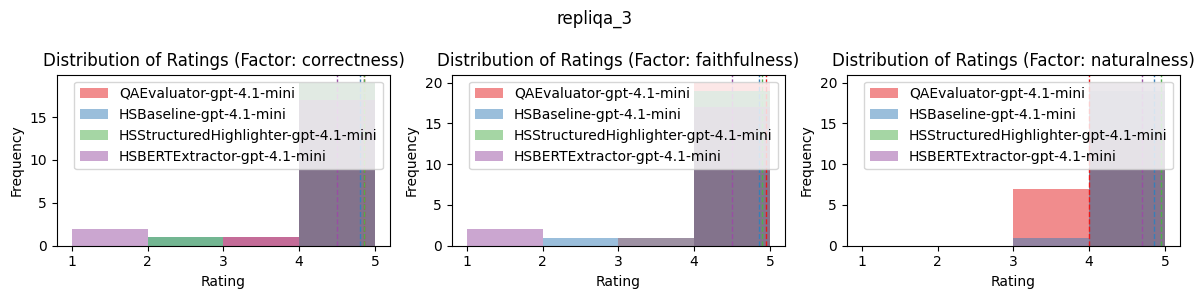

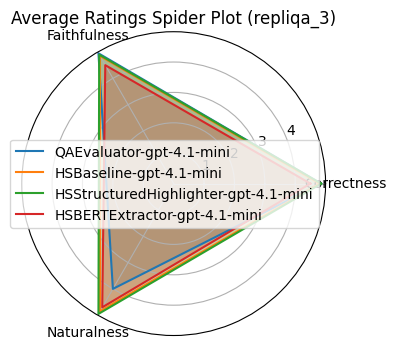

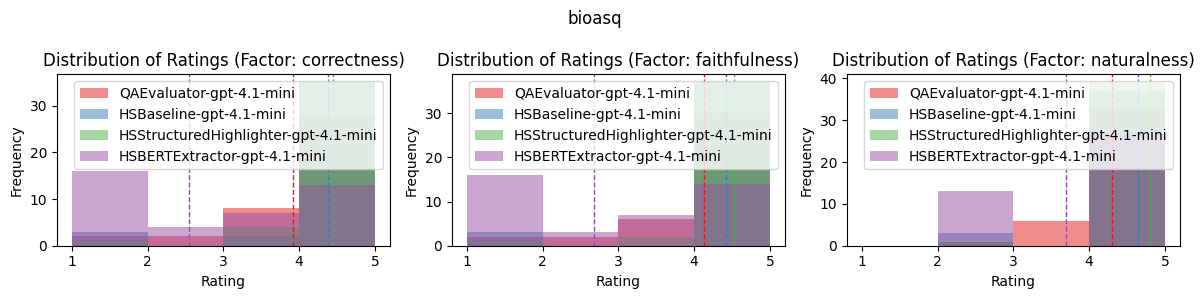

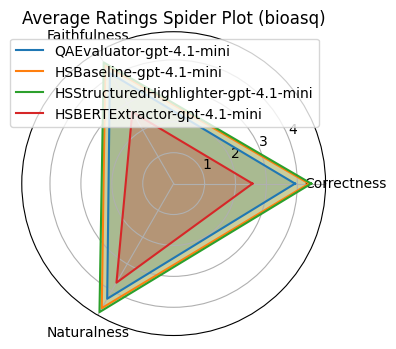

In [7]:
judge_name = "MT-bench-QA"
llms = ["gpt-4.1-mini"]
for dataset_name, dataset_ratings in ratings.items():
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 3))
    for factor, ax in zip(["correctness", "faithfulness", "naturalness"], axes.flatten()):
        #plt.figure(figsize=(4, 3))
        colors = sns.color_palette("Set1", n_colors=len(dataset_ratings))
        for model_name in dataset_ratings:
            model_ratings = dataset_ratings[model_name]
            color = colors.pop(0)
            judge_ratings = model_ratings[f"{judge_name}_{factor}"]
            ax.hist(judge_ratings, alpha=0.5, label=f"{model_name}", color=color, density=False, bins=np.arange(MIN_RATING, MAX_RATING + 1, 1))
            # A vertical line for each model's average rating.
            avg_rating = np.mean(judge_ratings)
            ax.axvline(avg_rating, linestyle='--', linewidth=1, color=color) #label=f"{model_name} Avg"

        ax.set_xlabel("Rating")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Distribution of Ratings (Factor: {factor})")
        # plt.suptitle(dataset_name)
        ax.set_xticks(np.arange(MIN_RATING, MAX_RATING + 1, 1))
        ax.legend()
        plt.suptitle(dataset_name)
        plt.tight_layout()
    
    # A spider plot for each model's average ratings.
    spider_data = {}
    for model_name in dataset_ratings:
        model_ratings = dataset_ratings[model_name]
        avg_ratings = [np.mean(model_ratings[f"{judge_name}_{factor}"]) for factor in ["correctness", "faithfulness", "naturalness"]]
        spider_data[model_name] = avg_ratings
    # Create a spider plot.
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
    num_vars = len(spider_data[next(iter(spider_data))])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    for model_name, avg_ratings in spider_data.items():
        avg_ratings += avg_ratings[:1]  # Complete the loop
        ax.plot(angles, avg_ratings, label=model_name)
        ax.fill(angles, avg_ratings, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(["Correctness", "Faithfulness", "Naturalness"])
    ax.set_title(f"Average Ratings Spider Plot ({dataset_name})")
    plt.legend()
    plt.tight_layout()

#### Unanswerable

Filter:   0%|          | 0/40 [00:00<?, ? examples/s]

Filter: 100%|██████████| 20/20 [00:00<00:00, 4199.34 examples/s]


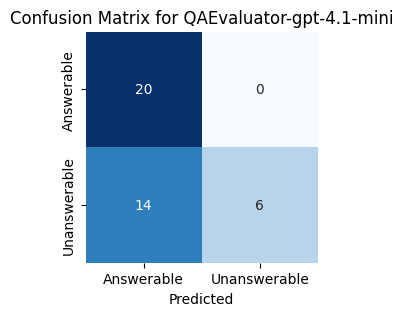

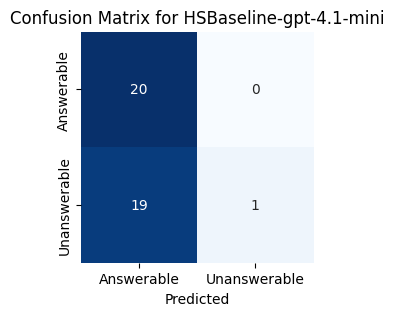

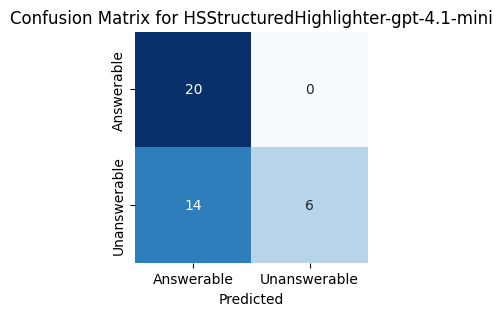

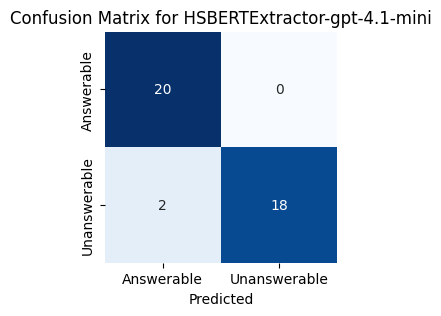

In [8]:
# Confusion matrix for (answer is answerable/unanswerable, answer_pred is answerable/unanswerable)
judged_dataset = inference_datasets["repliqa_3"]
for model_name in judged_dataset:
    answerable = judged_dataset[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED
    )
    unanswerable = judged_dataset[model_name].filter(
        lambda example: example["answer"] == NOANSWER_PRED
    )
    answerable_correct = len(answerable.filter(lambda example: example["answer_pred"] != NOANSWER_PRED))
    unanswerable_correct = len(unanswerable.filter(lambda example: example["answer_pred"] == NOANSWER_PRED))

    # Plot as confusion matrix.
    confusion_matrix = np.array([[answerable_correct, len(answerable) - answerable_correct],
                                  [len(unanswerable) - unanswerable_correct, unanswerable_correct]])
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted") 

#### Recall and K-F1

Referring to https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00667/121196.

In [9]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

def ref_answer_recall(answer, answer_pred):
    """This metric measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    if answer == NOANSWER_PRED:
        raise ValueError("Reference answer is NOANSWER_PRED.")

    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    answer_tokens = set(enc.encode(answer))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = answer_tokens.intersection(answer_pred_tokens)
    recall = len(common_tokens) / len(answer_tokens)
    return recall

def ref_passage_precision(passage, answer_pred):
    """This metric measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.
    """
    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    passage_tokens = set(enc.encode(passage))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = passage_tokens.intersection(answer_pred_tokens)
    precision = len(common_tokens) / len(answer_pred_tokens)
    return precision

Model: QAEvaluator-gpt-4.1-mini
  Ref Answer Recall: 0.6697
  Ref Passage Precision: 0.8101
Model: HSBaseline-gpt-4.1-mini
  Ref Answer Recall: 0.7633
  Ref Passage Precision: 0.7268
Model: HSBaseline-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7327
  Ref Passage Precision: 0.8795
Model: HSStructuredHighlighter-gpt-4.1-mini
  Ref Answer Recall: 0.8202
  Ref Passage Precision: 0.7334
Model: HSStructuredHighlighter-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7909
  Ref Passage Precision: 0.8879
Model: HSBERTExtractor-gpt-4.1-mini
  Ref Answer Recall: 0.7236
  Ref Passage Precision: 0.6389
Model: HSBERTExtractor-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.4530
  Ref Passage Precision: 0.7829
Skipping dataset bioasq for evaluation because it doesn't contain `long_answer`.


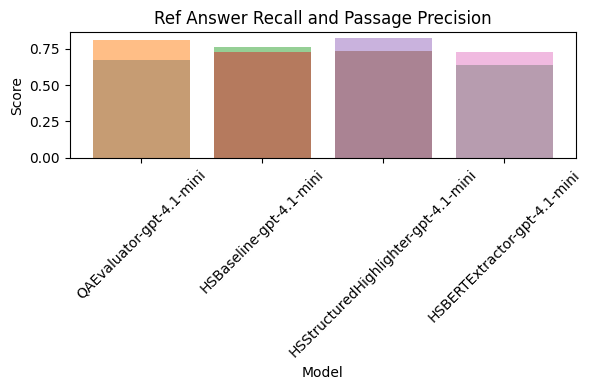

In [10]:
results = {}
for dataset_name, judged_predictions in inference_datasets.items():
    if dataset_name != "repliqa_3":
        print(f"Skipping dataset {dataset_name} for evaluation because it doesn't contain `long_answer`.")
        continue
    for model_name, dataset in judged_predictions.items():
        if not "mini" in model_name:
            continue
        results[model_name] = {
            "ref_answer_recall": [],
            "ref_passage_precision": [],
            "answer_length": [],
            "answer_pred_length": []
        }
        for example in dataset:
            # We skip unanswerable questions.
            if example["answer"] == NOANSWER_PRED:
                continue
            results[model_name]["ref_answer_recall"].append(
                ref_answer_recall(example["answer"], example["answer_pred"])
            )
            results[model_name]["ref_passage_precision"].append(
                ref_passage_precision(example["long_answer"], example["answer_pred"])
            )
        print(f"Model: {model_name}")
        print(f"  Ref Answer Recall: {np.mean(results[model_name]['ref_answer_recall']):.4f}")
        print(f"  Ref Passage Precision: {np.mean(results[model_name]['ref_passage_precision']):.4f}")

        # We also evaluate just the highlighter (i.e., no summarizer) for HS pipelines.
        if "HS" in model_name:
            results[f"{model_name}-highlighter"] = {
                "ref_answer_recall": [],
                "ref_passage_precision": [],
                "answer_length": [],
                "answer_pred_length": []
            }
            for example in dataset:
                if example["answer"] == NOANSWER_PRED:
                    continue
                results[f"{model_name}-highlighter"]["ref_answer_recall"].append(
                    ref_answer_recall(example["answer"], example["highlighter_extracted"])
                )
                results[f"{model_name}-highlighter"]["ref_passage_precision"].append(
                    ref_passage_precision(example["long_answer"], example["highlighter_extracted"])
                )
            print(f"Model: {model_name}-highlighter")
            print(f"  Ref Answer Recall: {np.mean(results[f'{model_name}-highlighter']['ref_answer_recall']):.4f}")
            print(f"  Ref Passage Precision: {np.mean(results[f'{model_name}-highlighter']['ref_passage_precision']):.4f}")

    # Plot the results as a bar chart.
    plt.figure(figsize=(6, 4))
    for model_name, result in results.items():
        if not "mini" in model_name:
            continue
        if "highlighter" in model_name:
            # Skip highlighter-only models for this plot.
            continue
        plt.bar(model_name, np.mean(result["ref_answer_recall"]), label=f"{model_name} Recall", alpha=0.5)
        plt.bar(model_name, np.mean(result["ref_passage_precision"]), label=f"{model_name} Precision", alpha=0.5)
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title("Ref Answer Recall and Passage Precision")
    plt.xticks(rotation=45)
    # plt.legend()
    plt.tight_layout()